In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d senihyildirim/road-defect-and-anomaly-detection


Dataset URL: https://www.kaggle.com/datasets/senihyildirim/road-defect-and-anomaly-detection
License(s): unknown
100% 7.29G/7.31G [01:02<00:00, 130MB/s]
100% 7.31G/7.31G [01:02<00:00, 126MB/s]


In [ ]:
import zipfile

# İndirilen veri seti zip dosyasını çıkartma
with zipfile.ZipFile("road-defect-and-anomaly-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")


In [ ]:
import os
import glob
import cv2
import numpy as np

# Dosya yolları
train_images_dir = '/content/dataset/images/train/images'
train_labels_dir = '/content/dataset/images/train/labels'
valid_images_dir = '/content/dataset/images/valid/images'
valid_labels_dir = '/content/dataset/images/valid/labels'

# İşleyeceğimiz sınıflar
target_classes = {2, 3, 4, 5}

# Etiket filtreleme fonksiyonu
def filter_labels_and_images(images_dir, labels_dir, target_classes):
    data = []
    for label_file in glob.glob(os.path.join(labels_dir, '*.txt')):
        with open(label_file, 'r') as f:
            lines = f.readlines()

        filtered_lines = [line for line in lines if int(line.split()[0]) in target_classes]

        if filtered_lines:
            image_file = os.path.join(images_dir, os.path.basename(label_file).replace('.txt', '.jpg'))
            if os.path.exists(image_file):
                data.append((image_file, filtered_lines))
    return data

# Veri hazırlama
train_data = filter_labels_and_images(train_images_dir, train_labels_dir, target_classes)
valid_data = filter_labels_and_images(valid_images_dir, valid_labels_dir, target_classes)

# Etiketleri one-hot encode yapma ve resimleri hazırlama
def prepare_data(data, target_classes):
    images = []
    labels = []
    for image_file, label_lines in data:
        image = cv2.imread(image_file)
        if image is None:
            continue
        image = cv2.resize(image, (224, 224))
        images.append(image)
        label = [0] * len(target_classes)
        for line in label_lines:
            class_id = int(line.split()[0])
            label[list(target_classes).index(class_id)] = 1
        labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = prepare_data(train_data, target_classes)
X_valid, y_valid = prepare_data(valid_data, target_classes)

print(f"Loaded {len(X_train)} training images and {len(X_valid)} validation images")


Loaded 3313 training images and 733 validation images


In [ ]:
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import time

# GPU kullanımı kontrolü
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Veri jeneratörü (augmented)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=64)
valid_generator = ImageDataGenerator(rescale=1./255).flow(X_valid, y_valid, batch_size=64)

# Callback sınıfı
class LiveAccuracyPlot(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        self.epochs = self.params['epochs']
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        avg_epoch_time = np.mean(self.epoch_times)
        time_elapsed = time.time() - self.start_time
        time_remaining = avg_epoch_time * (self.epochs - (epoch + 1))
        percent_complete = (epoch + 1) / self.epochs * 100

        train_acc = logs['accuracy'] * 100
        val_acc = logs['val_accuracy'] * 100

        print(f"Epoch {epoch + 1}/{self.epochs} - "
              f"{percent_complete:.2f}% complete - "
              f"Time: {epoch_time:.2f}s/epoch - "
              f"Elapsed: {time_elapsed:.2f}s - "
              f"Remaining: {time_remaining:.2f}s - "
              f"Training Accuracy: {train_acc:.2f}% - "
              f"Validation Accuracy: {val_acc:.2f}%")

# `content/models` klasörünü oluştur
os.makedirs('/content/models', exist_ok=True)

live_plot_callback = LiveAccuracyPlot()
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/models/best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Model oluşturma
model = Sequential([
    ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(target_classes), activation='softmax')
])

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(train_generator, validation_data=valid_generator, epochs=250, callbacks=[live_plot_callback, early_stopping, checkpoint])

# En iyi modelin yüklenmesi
model.load_weights('/content/models/best_model.keras')


Found GPU at: /device:GPU:0
Epoch 1/250
52/52 [==============================] - 71s 853ms/step - loss: 2.9328 - accuracy: 0.2958 - val_loss: 1.9828 - val_accuracy: 0.0696
Epoch 2/250
52/52 [==============================] - 39s 733ms/step - loss: 2.7055 - accuracy: 0.3773 - val_loss: 5.2177 - val_accuracy: 0.0628
Epoch 3/250
52/52 [==============================] - 39s 735ms/step - loss: 2.4383 - accuracy: 0.4253 - val_loss: 7.7583 - val_accuracy: 0.0614
Epoch 4/250
52/52 [==============================] - 39s 741ms/step - loss: 2.3322 - accuracy: 0.4727 - val_loss: 10.5066 - val_accuracy: 0.0614
Epoch 5/250
52/52 [==============================] - 39s 734ms/step - loss: 2.1962 - accuracy: 0.4971 - val_loss: 12.3051 - val_accuracy: 0.0614
Epoch 6/250
52/52 [==============================] - 39s 736ms/step - loss: 2.0912 - accuracy: 0.5255 - val_loss: 12.1545 - val_accuracy: 0.0614
Epoch 7/250
52/52 [==============================] - 39s 735ms/step - loss: 1.9403 - accuracy: 0.5509 - v

In [ ]:
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri setinin hazırlanması
test_images_dir = '/content/dataset/images/test/images'
test_labels_dir = '/content/dataset/images/test/labels'

# İşleyeceğimiz sınıflar
target_classes = [2, 3, 4, 5]  # Liste olarak tanımlandı

# Etiket filtreleme ve resimleri yükleme
def filter_labels_and_images(images_dir, labels_dir, target_classes):
    data = []
    for label_file in glob.glob(os.path.join(labels_dir, '*.txt')):
        with open(label_file, 'r') as f:
            lines = f.readlines()

        filtered_lines = [line for line in lines if int(line.split()[0]) in target_classes]

        if filtered_lines:
            image_file = os.path.join(images_dir, os.path.basename(label_file).replace('.txt', '.jpg'))
            if os.path.exists(image_file):
                data.append((image_file, filtered_lines))
    return data

# Veri hazırlama
test_data = filter_labels_and_images(test_images_dir, test_labels_dir, target_classes)

# Etiketleri one-hot encode yapma ve resimleri hazırlama
def prepare_data(data, target_classes):
    images = []
    labels = []
    for image_file, label_lines in data:
        image = cv2.imread(image_file)
        if image is None:
            continue
        image = cv2.resize(image, (224, 224))
        images.append(image)
        label = [0] * len(target_classes)
        for line in label_lines:
            class_id = int(line.split()[0])
            label[target_classes.index(class_id)] = 1
        labels.append(label)
    return np.array(images), np.array(labels)

X_test, y_test = prepare_data(test_data, target_classes)

# Veri jeneratörü
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Modelin yüklenmesi
model = tf.keras.models.load_model('/content/models/best_model.keras')


23/23 [==============================] - 7s 175ms/step
Classification Report:
              precision    recall  f1-score   support

           2       0.98      0.72      0.83       317
           3       0.85      0.95      0.90       344
           4       0.60      0.97      0.74        34
           5       0.45      0.86      0.60        29

    accuracy                           0.84       724
   macro avg       0.72      0.87      0.77       724
weighted avg       0.88      0.84      0.85       724



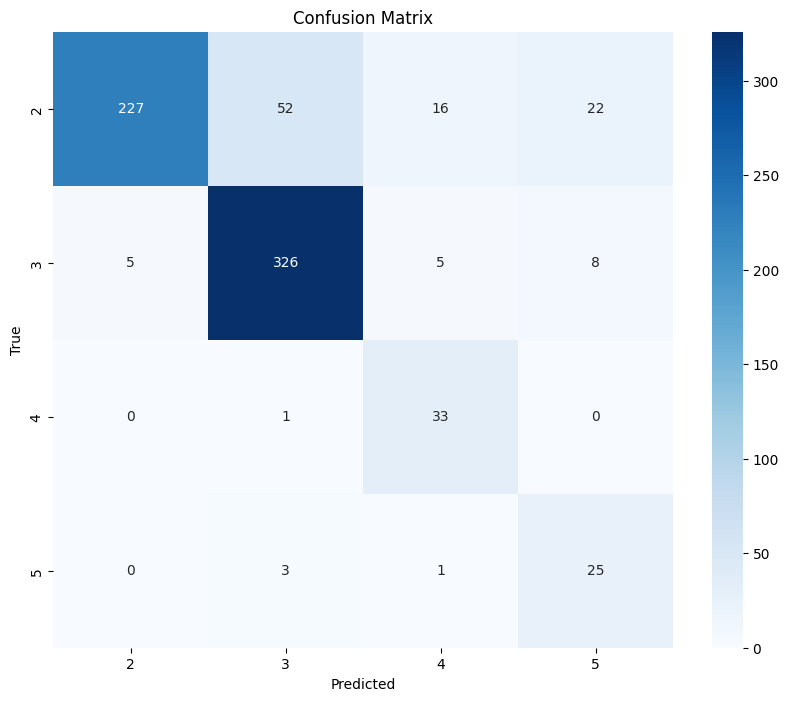

In [ ]:
# Test veri seti üzerinde tahmin yapma
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[str(c) for c in target_classes]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

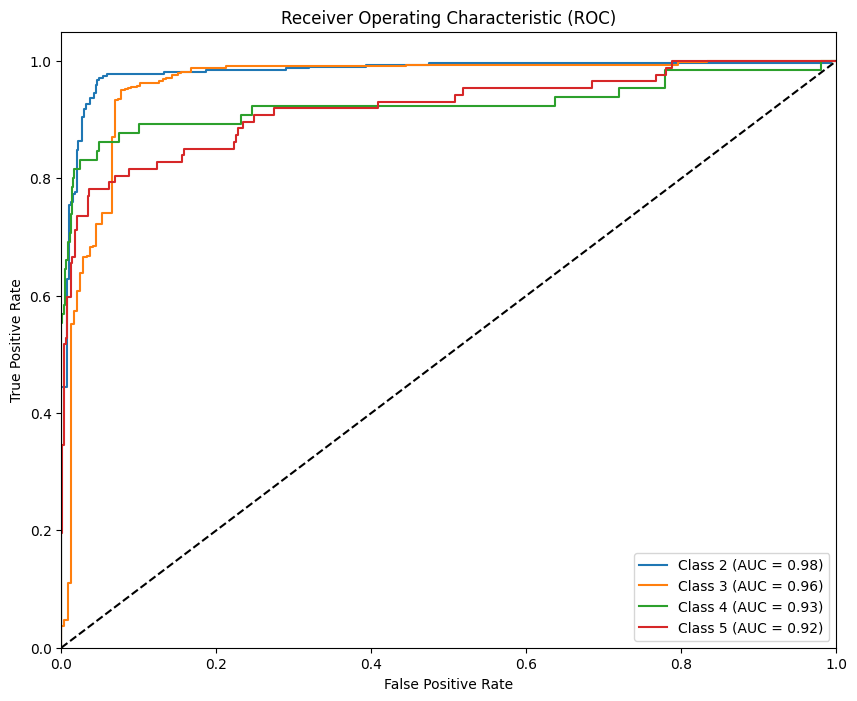

In [ ]:
# ROC eğrisi ve AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(target_classes)):
    if np.sum(y_test[:, i]) > 0:  # Pozitif örneklerin olup olmadığını kontrol et
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        fpr[i], tpr[i], roc_auc[i] = [0], [0], 0  # Pozitif örnek yoksa geçerli bir ROC eğrisi hesaplanamaz

# Her sınıf için ROC eğrisi
plt.figure(figsize=(10, 8))
for i in range(len(target_classes)):
    if len(fpr[i]) > 1:  # Geçerli bir ROC eğrisi varsa çiz
        plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(target_classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

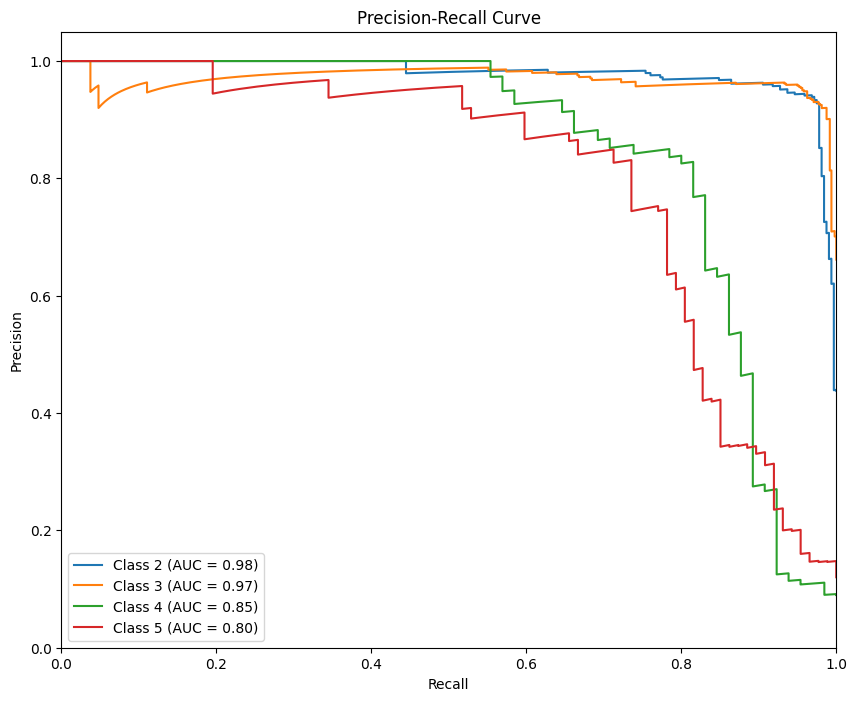

In [ ]:
# Precision-Recall eğrisi
precision = {}
recall = {}
pr_auc = {}

for i in range(len(target_classes)):
    if np.sum(y_test[:, i]) > 0:  # Pozitif örneklerin olup olmadığını kontrol et
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_prob[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
    else:
        precision[i], recall[i], pr_auc[i] = [0], [0], 0  # Pozitif örnek yoksa geçerli bir PR eğrisi hesaplanamaz

# Her sınıf için Precision-Recall eğrisi
plt.figure(figsize=(10, 8))
for i in range(len(target_classes)):
    if len(precision[i]) > 1:  # Geçerli bir PR eğrisi varsa çiz
        plt.plot(recall[i], precision[i], label='Class {} (AUC = {:.2f})'.format(target_classes[i], pr_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [ ]:
# F1-Score
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1-Score: {:.2f}".format(f1))

F1-Score: 0.85


In [ ]:
import os
import glob
from collections import Counter

# Etiketlerin bulunduğu dizin
train_labels_dir = '/content/dataset/images/test/labels'

# Sınıf sayımlarını tutmak için bir Counter nesnesi oluşturun
class_counts = Counter()

# Etiket dosyalarını oku ve sınıf sayımlarını güncelle
for label_file in glob.glob(os.path.join(train_labels_dir, '*.txt')):
    with open(label_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

# Her sınıfın kaç örneği olduğunu yazdır
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} instances")


Class 1: 2158 instances
Class 5: 98 instances
Class 0: 647 instances
Class 3: 970 instances
Class 2: 561 instances
Class 4: 70 instances


In [ ]:
import os
import cv2

# Görüntülerin bulunduğu dizin
image_dir = '/content/dataset/images/test/images'

# Tüm görüntülerin boyutlarını öğrenmek için
image_shapes = []

for image_file in os.listdir(image_dir):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            image_shapes.append(image.shape)

# İlk birkaç görüntünün boyutlarını yazdır
for i, shape in enumerate(image_shapes[:5]):
    print(f"Image {i+1} shape: {shape}")

# Görüntü boyutlarını analiz etmek için
unique_shapes = set(image_shapes)
print(f"Unique image shapes: {unique_shapes}")

Image 1 shape: (1080, 1920, 3)
Image 2 shape: (1080, 1920, 3)
Image 3 shape: (1080, 1920, 3)
Image 4 shape: (1080, 1920, 3)
Image 5 shape: (1080, 1920, 3)
Unique image shapes: {(1080, 1920, 3)}
